In [1]:
import os
from typing import Tuple
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.io.image import read_image
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from data.utils import walk_path

In [2]:
from utils.helper_functions import load_shift_ood, load_shift_segmentation, load_streethazards_ood, load_streethazards_segmentation
from data.shift_dataset import LabelFilter

In [3]:
# ds_train, ds_val, ds_test = load_shift_segmentation(
#     "./datasets/SHIFT", 512, 4, LabelFilter("4", -1, 0), LabelFilter("4", -1, 0), "ood_pedestrian", 1, .05)

In [4]:
# ds_train, ds_val, ds_test = load_shift_ood(
#     "./datasets/SHIFT", 512,
#     "./datasets/COCO2014", 256, 4, LabelFilter("4", -1, 0), LabelFilter("4", 10000, 15000), "ood_pedestrian",
#     .7, .9, True, 3, 1, .05)

In [5]:
# ds_train, ds_val, ds_test = load_streethazards_ood(
#     "./datasets/StreetHazards", 512,
#     "./datasets/COCO2014", 256, 4, "normal",
#     .7, .9, True, 3, 1)

loading annotations into memory...
Done (t=3.04s)
creating index...
index created!


In [12]:
ds_train, ds_val, ds_test = load_streethazards_segmentation(
    "./datasets/StreetHazards", 512, 4, "normal", 1)

In [16]:
l =  enumerate(ds_test)

In [17]:
i, data = next(l)

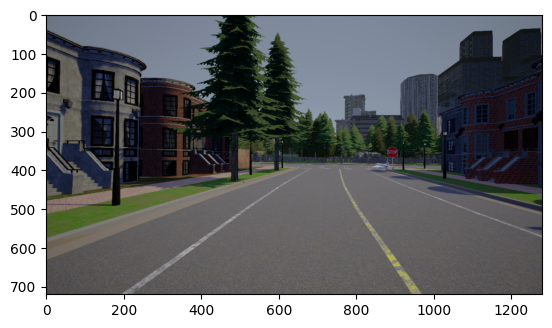

In [18]:
plt.imshow(data[0][0].permute((1, 2, 0)))

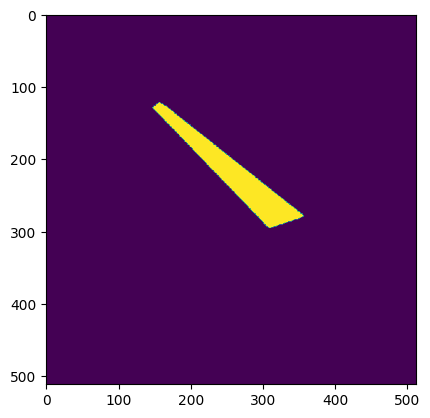

In [11]:
plt.imshow(data[1][0]==101)